# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)

In [1]:
import json
import warnings
from datetime import datetime, date, timedelta
from pytz import timezone
from numbers import Number

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt, dates as mdates, cbook, image 

# credits and installation https://github.com/njchiang/tikhonov.git
from sklearn.linear_model import LinearRegression
from tikhonov.TikhonovRegression import Tikhonov

from scipy import stats

# Markov chain Monte Carlo
import arviz as az
import pymc3 as pm
import theano.tensor as tt

warnings.simplefilter(action="ignore", category=(FutureWarning,UserWarning))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def plot_series(title, df, yfields, xfield='data', ylim=None, xlim=None):
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)    
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    
    with open('./images/watermark.png', 'rb') as file:
        im = image.imread(file)
    fig.figimage(im, 1150, 850, zorder=3, alpha=.5)        
    
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)

    for f in yfields:
        ax1.plot(
            df[xfield], 
            df[f], 
            label=f, 
            linestyle=':', marker='o'
        )

    _ = ax1.legend(fontsize=27, loc='upper left')   

In [3]:
def plot_MCMC_sampling(df, column, ISS_df, ylim=(0,3), xlim=None, average=True, std=True, conf_int=False, path=None, dpi=None):
            
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title('', fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    

    updatemessage = 'Aggiornamento del {}'.format(
        datetime.now(tz=timezone('Europe/Rome')).strftime('%d %b %Y ore %H:%M'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
    ax1.text(0.65, 0.97, updatemessage, transform=ax1.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)    
    
    ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)
        
    ax1.plot(
        df['data'], 
        df['{}_Rt_MCMC'.format(column)], 
        label='Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
        marker='o', color = 'orange'
    )

    if conf_int:
        ax1.fill_between(
            df['data'], 
            df['{}_Rt_MCMC_CI_95_min'.format(column)],
            df['{}_Rt_MCMC_CI_95_max'.format(column)],
            color='orange', alpha=.3,
            label="95% confidence interval"
        )

    print('{}_Rt_MCMC_HDI_95_min'.format(column))
    ax1.fill_between(
        df.data, 
        df['{}_Rt_MCMC_HDI_95_min'.format(column)],
        df['{}_Rt_MCMC_HDI_95_max'.format(column)],
        color='violet', alpha=.3, 
        label = '95% credible interval'
    )

    if average:
        ax1.plot(
            df['data'], 
            df['{}_Rt_MCMC_avg14'.format(column)], 
            label='Avg14 Rt MCMC Estimate - {}'.format(column),
            marker='o', color = 'green'
        )    

    if std:
        ax1.fill_between(
            df['data'], 
            df['{}_Rt_MCMC_CI_95_14_min'.format(column)],
            df['{}_Rt_MCMC_CI_95_14_max'.format(column)],
            color='blue', alpha=.25,
            label="95% confidence interval on 14 days average"
        )
        
    ax1.errorbar(
        ISS_df.Rt_reference_date, 
        ISS_df.Rt, 
        ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
        uplims=True, lolims=True,
        label='Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con intervallo di credibilità 95%',
        marker='o', color = 'blue'
    )


    _ = ax1.legend(fontsize=27, loc='lower right')
    
    if path:
        plt.savefig(path, dpi=dpi)

# Two data sources

We have two official data sources:

- ISS data (Istituto Superiore della Sanita')
- pcm-dpc data (Protezione Civile)

See https://www.epicentro.iss.it/coronavirus/sars-cov-2-sorveglianza , at "Perché le informazioni fornite dall’ISS possono differire (essere in ritardo) rispetto a quelle della Protezione civile"


## ISS data (Istituto Superiore della Sanita')

These data are available via the Ministero della Sanita' web site, not in their raw format, but only via descriptive reports.

To obtain the data  one needs to navigate (or scrape) the intricated and non standardized structure of the weekly reports from ministero della Sanita'

What follows is the result of the scraping, aimed to obtain the $Rt$ values computed by ISS.

In the "url" column the url to the official report is reported.

To update the ISS dataset, check manuallty [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.

In [4]:
ISS_Rt = pd.read_csv(
    './data/sources/Rt_from_ISS.csv',
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [5]:
ISS_Rt.head()

,ID,report_time_range_descr,computation_time_range_descr,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,notes,source,source_detail,url
0,5182,9 - 15 novembre,28 ottobre– 10 novembre,2020-10-28,2020-11-10,1.18,0.94,1.49,NaN,attachement,NaN,http://www.salute.gov.it/imgs/C_17_notizie_518...
1,5169,2 - 8 novembre,22 ottobre - 4 novembre,2020-10-22,2020-11-04,1.43,1.08,1.81,NaN,attachement,imgs/C_17_notizie_5169_0_file.pdf,http://www.salute.gov.it/portale/nuovocoronavi...
2,5157,26 ottobre - 1 novembre,15 - 28 ottobre,2020-10-15,2020-10-28,1.72,1.45,1.83,NaN,attachement,/portale/news/documenti/Epi_aggiornamenti/alle...,http://www.salute.gov.it/portale/nuovocoronavi...
3,5146,19 - 25 ottobre,08 - 21 ottobre 2020,2020-10-08,2020-10-21,1.70,1.49,1.85,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...
4,5137,12-18 ottobre,01 - 14 ottobre 2020,2020-10-01,2020-10-14,1.50,1.09,1.75,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...


In [6]:
ISS_Rt_clean = ISS_Rt.loc[:,[
    'computation_time_range_start','computation_time_range_end','Rt','Rt_95_min','Rt_95_max'
]].dropna()

In [7]:
ISS_Rt_clean['Rt_95_err_max'] = ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt
ISS_Rt_clean['Rt_95_err_min'] = np.abs(ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt)

In [8]:
ISS_Rt_clean['Rt_reference_date'] = (
    (
        ISS_Rt_clean.computation_time_range_start + 
        (ISS_Rt_clean.computation_time_range_end - ISS_Rt_clean.computation_time_range_start)/2
    ).dt.normalize()+timedelta(days=1, seconds=-1)
)

In [9]:
ISS_Rt_clean.head()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
0,2020-10-28,2020-11-10,1.18,0.94,1.49,0.31,0.31,2020-11-03 23:59:59
1,2020-10-22,2020-11-04,1.43,1.08,1.81,0.38,0.38,2020-10-28 23:59:59
2,2020-10-15,2020-10-28,1.72,1.45,1.83,0.11,0.11,2020-10-21 23:59:59
3,2020-10-08,2020-10-21,1.70,1.49,1.85,0.15,0.15,2020-10-14 23:59:59
4,2020-10-01,2020-10-14,1.50,1.09,1.75,0.25,0.25,2020-10-07 23:59:59


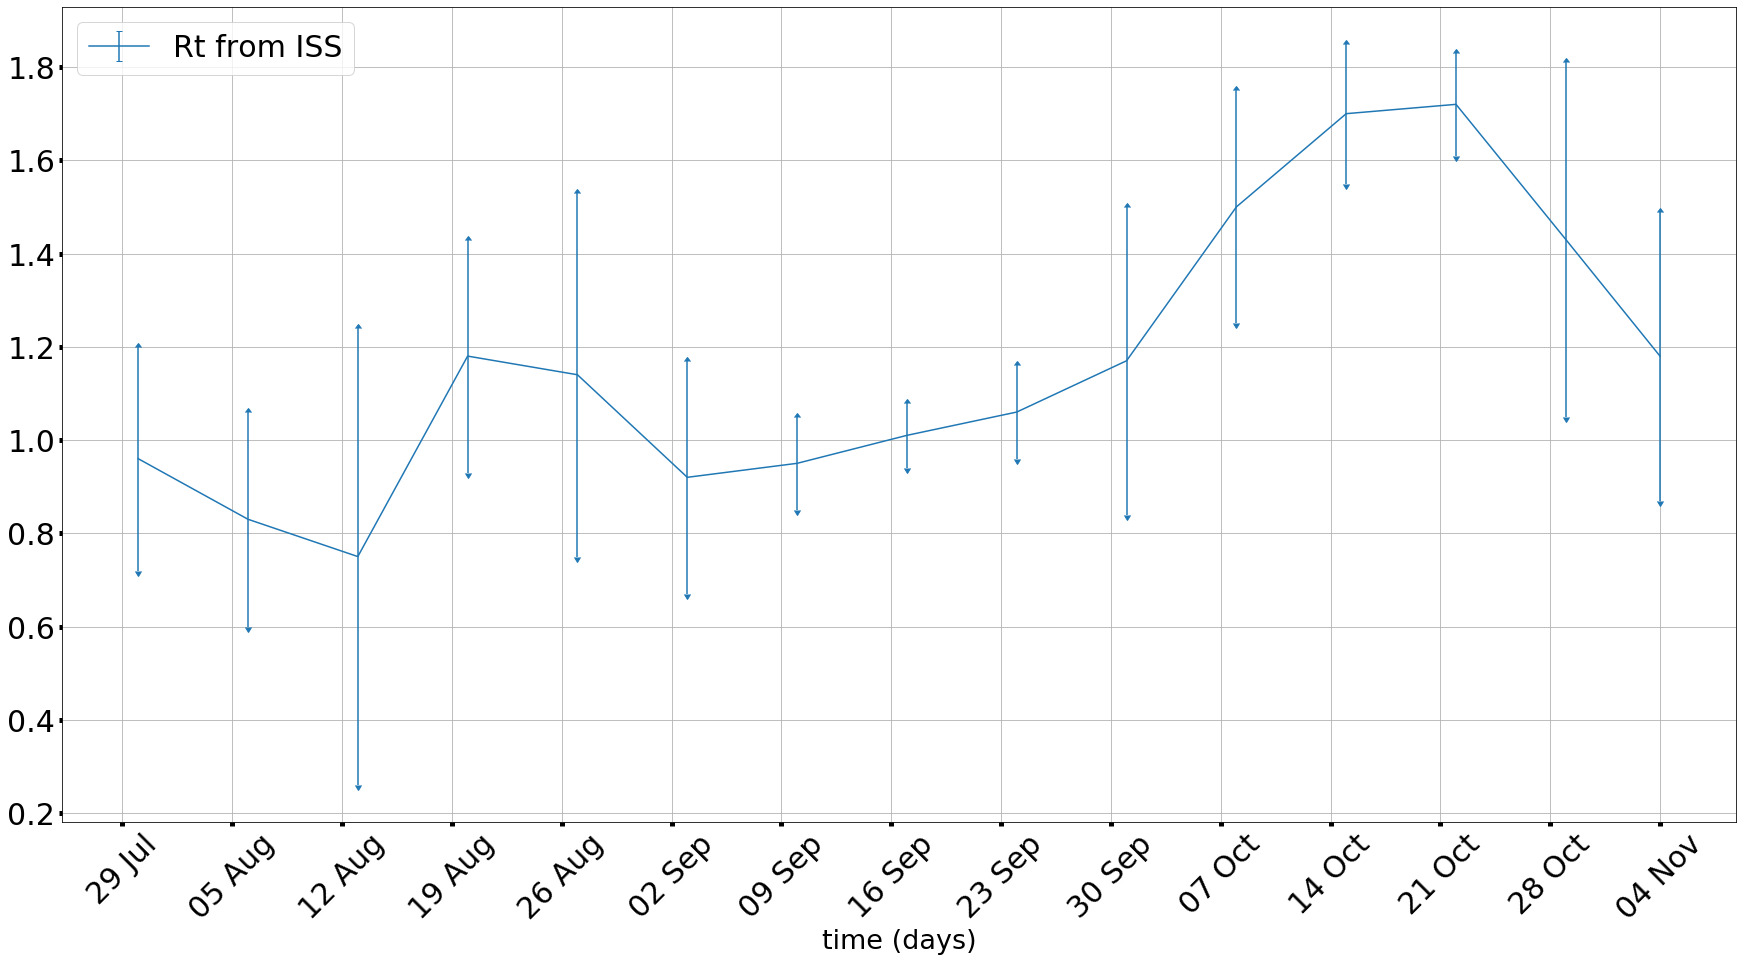

In [10]:
fig, ax1 = plt.subplots(figsize=(30,15))

ax1.set_xlabel('time (days)', fontsize=27)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax1.xaxis.set_tick_params(width=5)
ax1.yaxis.set_tick_params(width=5)

ax1.grid()    

ax1.set_ylabel('', fontsize=30)
ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS'
)

_ = ax1.legend(fontsize=30)

By the way, this happens to be the only publicly available chart of the ISS computed Rt value, at least to my knowledge.

## Assessing the confidence interval

- why are confidence intervals so different?
- why are they so big?

Confidence bars seems pretty related with the derivative of the signal.
Given that the ISS $R_t$ is the average over 14 days, the hypothesis could be that the confidence intervals are simpli an estimate of the slope of the 14 points averaged. 
The bigger the slope the bigger the confidence interval.

Let's check this hypothesis comparing the amplitude of the confidence intervals with $2(R_{t} - R_{t-7})$, with $2$ being motivated by the fact that the points are 7 days distant, while the averages are taken on 14 days ranges.


In [11]:
ISS_Rt_clean['Rt_95_CI'] = 2*ISS_Rt_clean.Rt_95_err_max
ISS_Rt_clean['Rt_2_abs_D'] = 2*(np.abs(ISS_Rt_clean.Rt - ISS_Rt_clean.Rt.shift(1)))

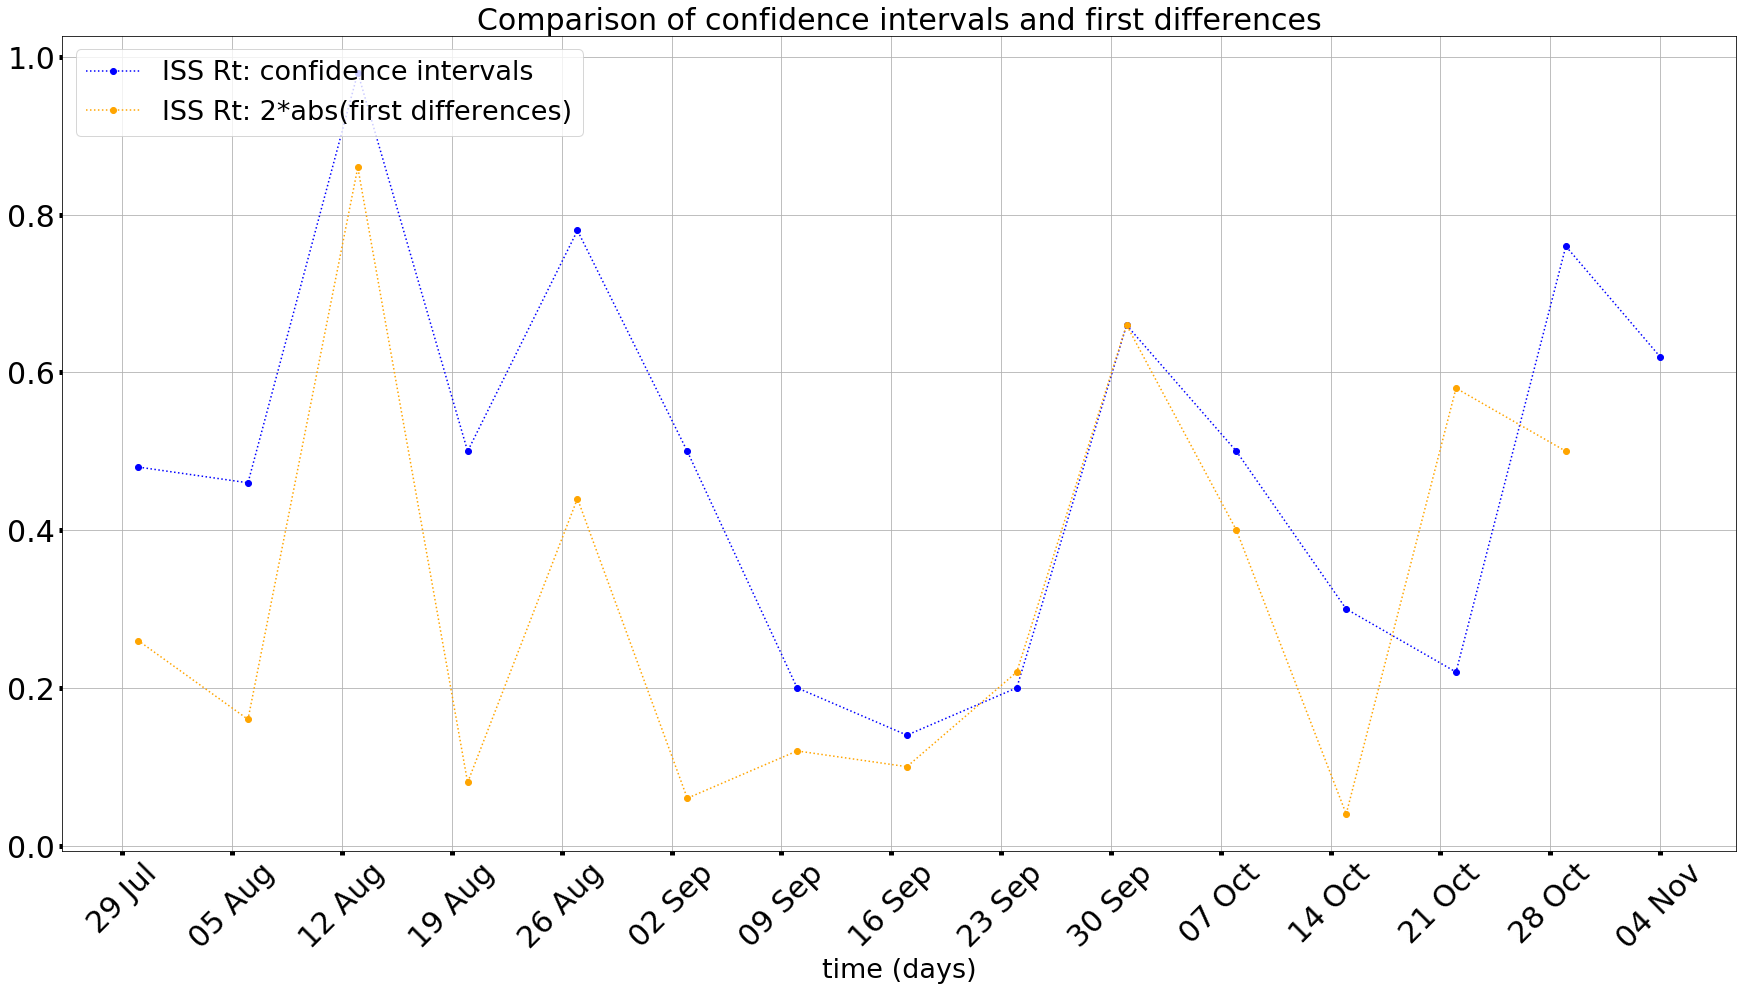

In [12]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Comparison of confidence intervals and first differences', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=27)
ax1.tick_params(axis='both', labelsize=30)

ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax1.xaxis.set_tick_params(width=5)
ax1.yaxis.set_tick_params(width=5)

ax1.grid()    

ax1.plot(
    ISS_Rt_clean.Rt_reference_date,
    ISS_Rt_clean.Rt_95_CI, 
    label='ISS Rt: confidence intervals', 
    linestyle=':', marker='o', color = 'blue'
)

ax1.plot(
    ISS_Rt_clean.Rt_reference_date,
    ISS_Rt_clean.Rt_2_abs_D,
    label='ISS Rt: 2*abs(first differences)', 
    linestyle=':', marker='o', color = 'orange'
)

_ = ax1.legend(fontsize=27, loc='upper left')    

# pcm-dpc data (Protezione Civile)

In [13]:
def parse_date_pcm(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [14]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date_pcm
)

In [15]:
italy_raw_data.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24 23:59:00,ITA,101,26,127,94,221,0,221,1,7,NaN,NaN,229,4324,NaN,NaN
1,2020-02-25 23:59:00,ITA,114,35,150,162,311,90,93,1,10,NaN,NaN,322,8623,NaN,NaN
2,2020-02-26 23:59:00,ITA,128,36,164,221,385,74,78,3,12,NaN,NaN,400,9587,NaN,NaN
3,2020-02-27 23:59:00,ITA,248,56,304,284,588,203,250,45,17,NaN,NaN,650,12014,NaN,NaN
4,2020-02-28 23:59:00,ITA,345,64,409,412,821,233,238,46,21,NaN,NaN,888,15695,NaN,NaN


In [16]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

In [17]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

## Check data consistency

In [18]:
italy_raw_data.describe()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,156.000000,156.000000,2.780000e+02,2.780000e+02,2.230000e+02
mean,10000.561151,1094.208633,11094.773381,100255.133094,111349.902878,2833.352518,5533.780576,176005.187050,30112.593525,328286.282051,117387.948718,3.174677e+05,6.898414e+06,5.150519e+06
std,10718.830874,1300.175498,11988.682560,180305.429624,188626.969537,7029.496336,9909.289875,124651.686074,12238.295918,189265.676456,153841.559672,3.004328e+05,5.641572e+06,3.083785e+06
min,101.000000,26.000000,127.000000,94.000000,221.000000,-9098.000000,78.000000,1.000000,7.000000,221994.000000,15801.000000,2.290000e+02,4.324000e+03,9.353100e+05
25%,1162.000000,97.250000,1253.500000,14003.000000,15675.750000,-317.750000,343.000000,81960.250000,28932.750000,223224.250000,25301.750000,2.110222e+05,2.163180e+06,2.831848e+06
50%,4550.000000,372.500000,4975.500000,36607.000000,43426.000000,522.000000,1399.000000,194753.500000,34949.500000,234986.500000,49001.500000,2.429440e+05,5.919682e+06,4.273957e+06
75%,17516.000000,1860.000000,19084.250000,73886.750000,97924.000000,2215.750000,4176.000000,217488.750000,35686.000000,312094.250000,114201.500000,2.961598e+05,1.032358e+07,7.023133e+06
max,34697.000000,4068.000000,38507.000000,767867.000000,805947.000000,33418.000000,40902.000000,696647.000000,53677.000000,928191.000000,610026.000000,1.538217e+06,2.141170e+07,1.272941e+07


In [19]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

False

In [20]:
italy_raw_data.loc[
    italy_raw_data.totale_positivi 
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']
]

,data,totale_positivi,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,443235,307378,39747,790377


In [21]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    != italy_raw_data.totale_ospedalizzati,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati
1,2020-02-25 23:59:00,114,35,150


In [22]:
italy_raw_data.loc[
    italy_raw_data.totale_ospedalizzati 
    + italy_raw_data.isolamento_domiciliare 
    != italy_raw_data.totale_positivi,
    ['data', 'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi']    
]

,data,totale_ospedalizzati,isolamento_domiciliare,totale_positivi
1,2020-02-25 23:59:00,150,162,311


In [23]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    != italy_raw_data.totale_positivi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'totale_positivi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,totale_positivi


In [24]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'dimessi_guariti', 'deceduti', 'totale_casi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,22116,2292,418827,307378,39747,790377


# Fix NaN data

`casi_da_sospetto_diagnostico` and `casi_da_screening` have been measured only after a certain date

In [25]:
FIRST_CASI_SOSP_DIAGNOSTICO = italy_raw_data.casi_da_sospetto_diagnostico.first_valid_index()
italy_raw_data.loc[FIRST_CASI_SOSP_DIAGNOSTICO,['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [26]:
italy_raw_data.loc[italy_raw_data.casi_da_screening.first_valid_index(),['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [27]:
italy_raw_data.casi_da_sospetto_diagnostico.fillna(0, inplace=True)
italy_raw_data.casi_da_screening.fillna(0, inplace=True)

# Compute new cases

In [28]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico'] = \
    (italy_raw_data.casi_da_sospetto_diagnostico -
     italy_raw_data.casi_da_sospetto_diagnostico.shift(1)).fillna(0)

In [29]:
italy_raw_data['nuovi_casi_da_screening'] = \
    (italy_raw_data.casi_da_screening -
     italy_raw_data.casi_da_screening.shift(1)).fillna(0)

# Smoothing data via Tikhonov regularization

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a byproduct of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tri`, `np.ones` and `np.eye`.


In [30]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [31]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [32]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [33]:
italy_raw_data['tamponi_giornalieri'] = (italy_raw_data.tamponi - italy_raw_data.tamponi.shift(1)).fillna(0)
italy_raw_data['tamponi_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.tamponi, 
                                                                      X=INTEGRAL_MATRIX,
                                                                      L=GAMMA,
                                                                      alpha=ALPHA)

TIC R2: 0.9999912964046397


In [34]:
italy_raw_data['dimessi_guariti_giornalieri'] = (italy_raw_data.dimessi_guariti - italy_raw_data.dimessi_guariti.shift(1)).fillna(0)
italy_raw_data['dimessi_guariti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.dimessi_guariti,
                                                                              X=INTEGRAL_MATRIX,
                                                                              L=GAMMA,
                                                                              alpha=ALPHA)

TIC R2: 0.9999381514242518


In [35]:
italy_raw_data['deceduti_giornalieri'] = (italy_raw_data.deceduti - italy_raw_data.deceduti.shift(1)).fillna(0)
italy_raw_data['deceduti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.deceduti,
                                                                       X=INTEGRAL_MATRIX,
                                                                       L=GAMMA,
                                                                       alpha=200.)

TIC R2: 0.9999904257558611


In [36]:
italy_raw_data['nuovi_positivi_smoothed'] = smooth_differentiate(italy_raw_data.totale_casi,
                                                                 X=INTEGRAL_MATRIX,
                                                                 L=GAMMA,
                                                                 alpha=ALPHA)

TIC R2: 0.9999758117867391


In [37]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_sospetto_diagnostico,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9977515812038007


In [38]:
italy_raw_data['nuovi_casi_da_screening_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_screening,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9999364134642111


In [39]:
filter_columns = [
    'ricoverati_con_sintomi', 'terapia_intensiva',
    'isolamento_domiciliare', 'totale_positivi',
    'dimessi_guariti', 'deceduti', 'tamponi', 'totale_casi', 'casi_da_screening',
    'casi_da_sospetto_diagnostico'
]

for col in filter_columns:
    italy_raw_data[col+'_smoothed'] = smooth_data(y=italy_raw_data[col],
                                              X=INTEGRAL_MATRIX,
                                              L=GAMMA,
                                              alpha=ALPHA)

TIC R2: 0.9998102993705553
TIC R2: 0.999870482629556
TIC R2: 0.9998951811055217
TIC R2: 0.9999057360432096
TIC R2: 0.9999381514242518
TIC R2: 0.999991075963142
TIC R2: 0.9999912964046397
TIC R2: 0.9999758117867391
TIC R2: 0.9999364134642111
TIC R2: 0.9977515812038007


# Residuals

Check the residuals of the raw signals versus the smoothed ones, specifically for the following fields:

- `nuovi_positivi`
- `nuovi_casi_da_accertamento_diagnostico`
- `nuovi_casi_da_screening`

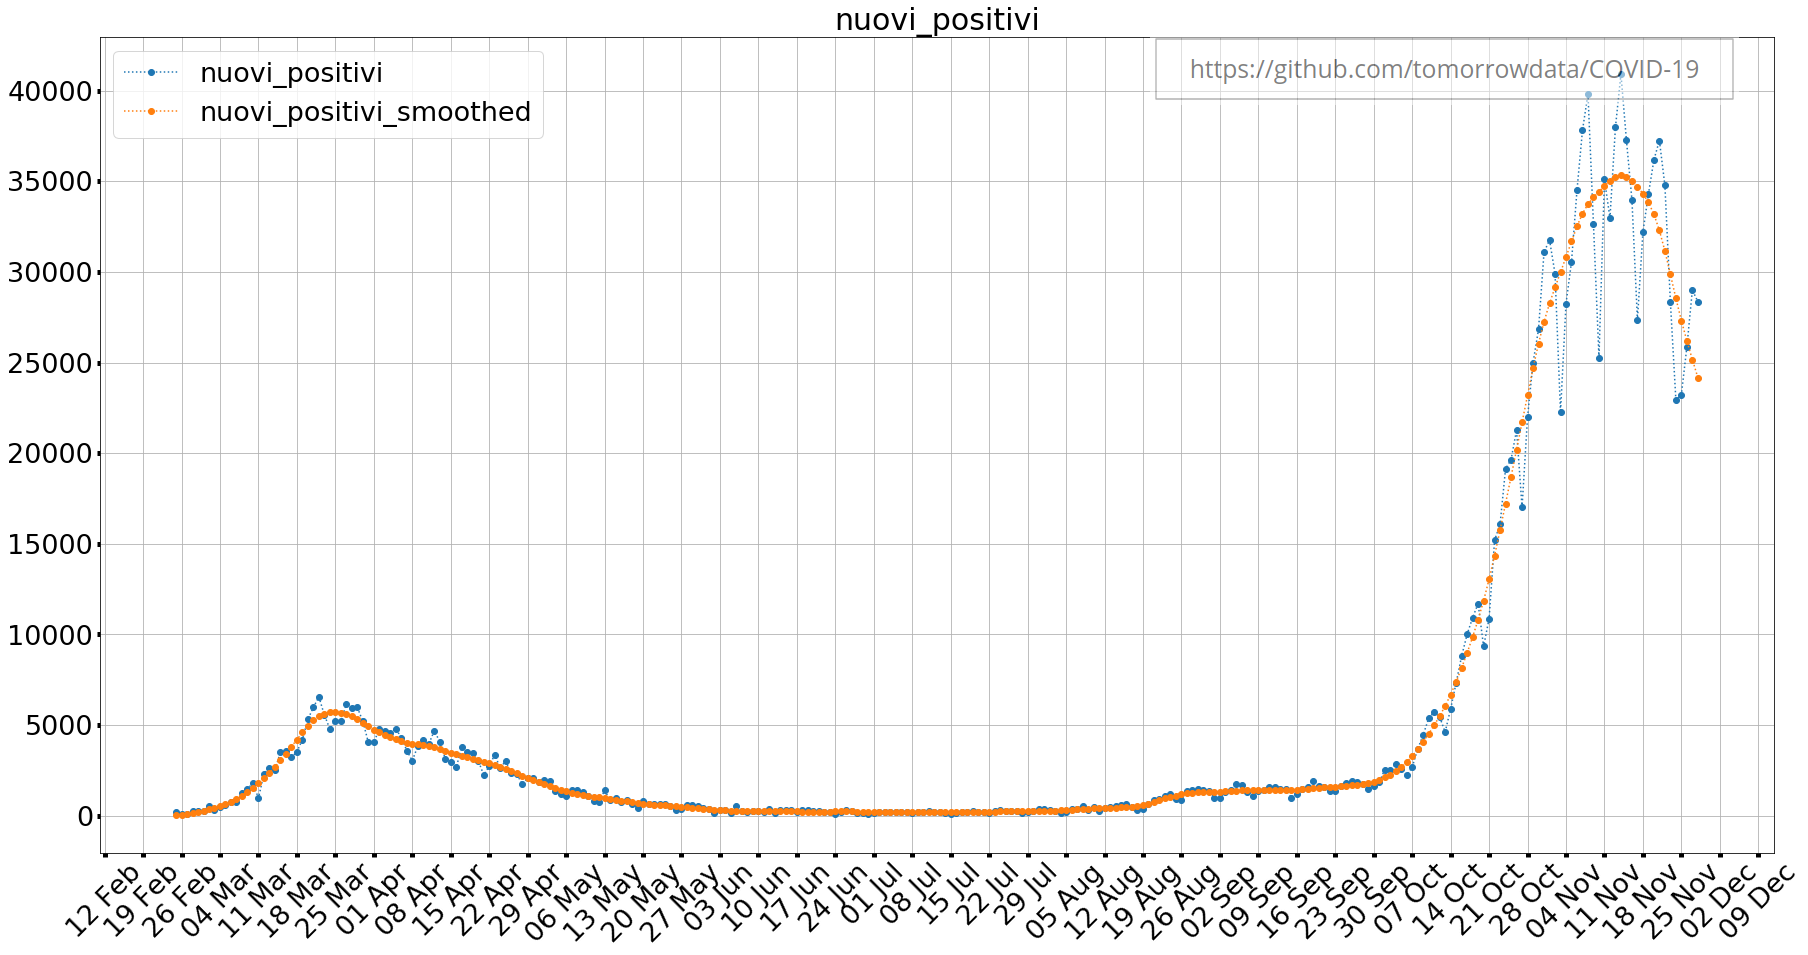

In [40]:
plot_series(
    'nuovi_positivi',    
    italy_raw_data, 
    [
        'nuovi_positivi',
        'nuovi_positivi_smoothed'
    ]
)

In [41]:
italy_raw_data['nuovi_positivi_residuals'] = (
    italy_raw_data.nuovi_positivi - italy_raw_data.nuovi_positivi_smoothed
)
italy_raw_data['nuovi_positivi_relative_residuals'] = (
    italy_raw_data.nuovi_positivi_residuals / italy_raw_data.nuovi_positivi_smoothed
)
italy_raw_data.loc[0,'nuovi_positivi_relative_residuals'] = 0

In [42]:
italy_raw_data['nuovi_positivi_residuals_sigma7'] = italy_raw_data.nuovi_positivi_residuals.rolling(
    window=7
).std()

italy_raw_data.nuovi_positivi_residuals_sigma7.fillna(
    italy_raw_data.nuovi_positivi_residuals_sigma7[
        italy_raw_data.nuovi_positivi_residuals_sigma7.first_valid_index()
    ],
    inplace=True
)

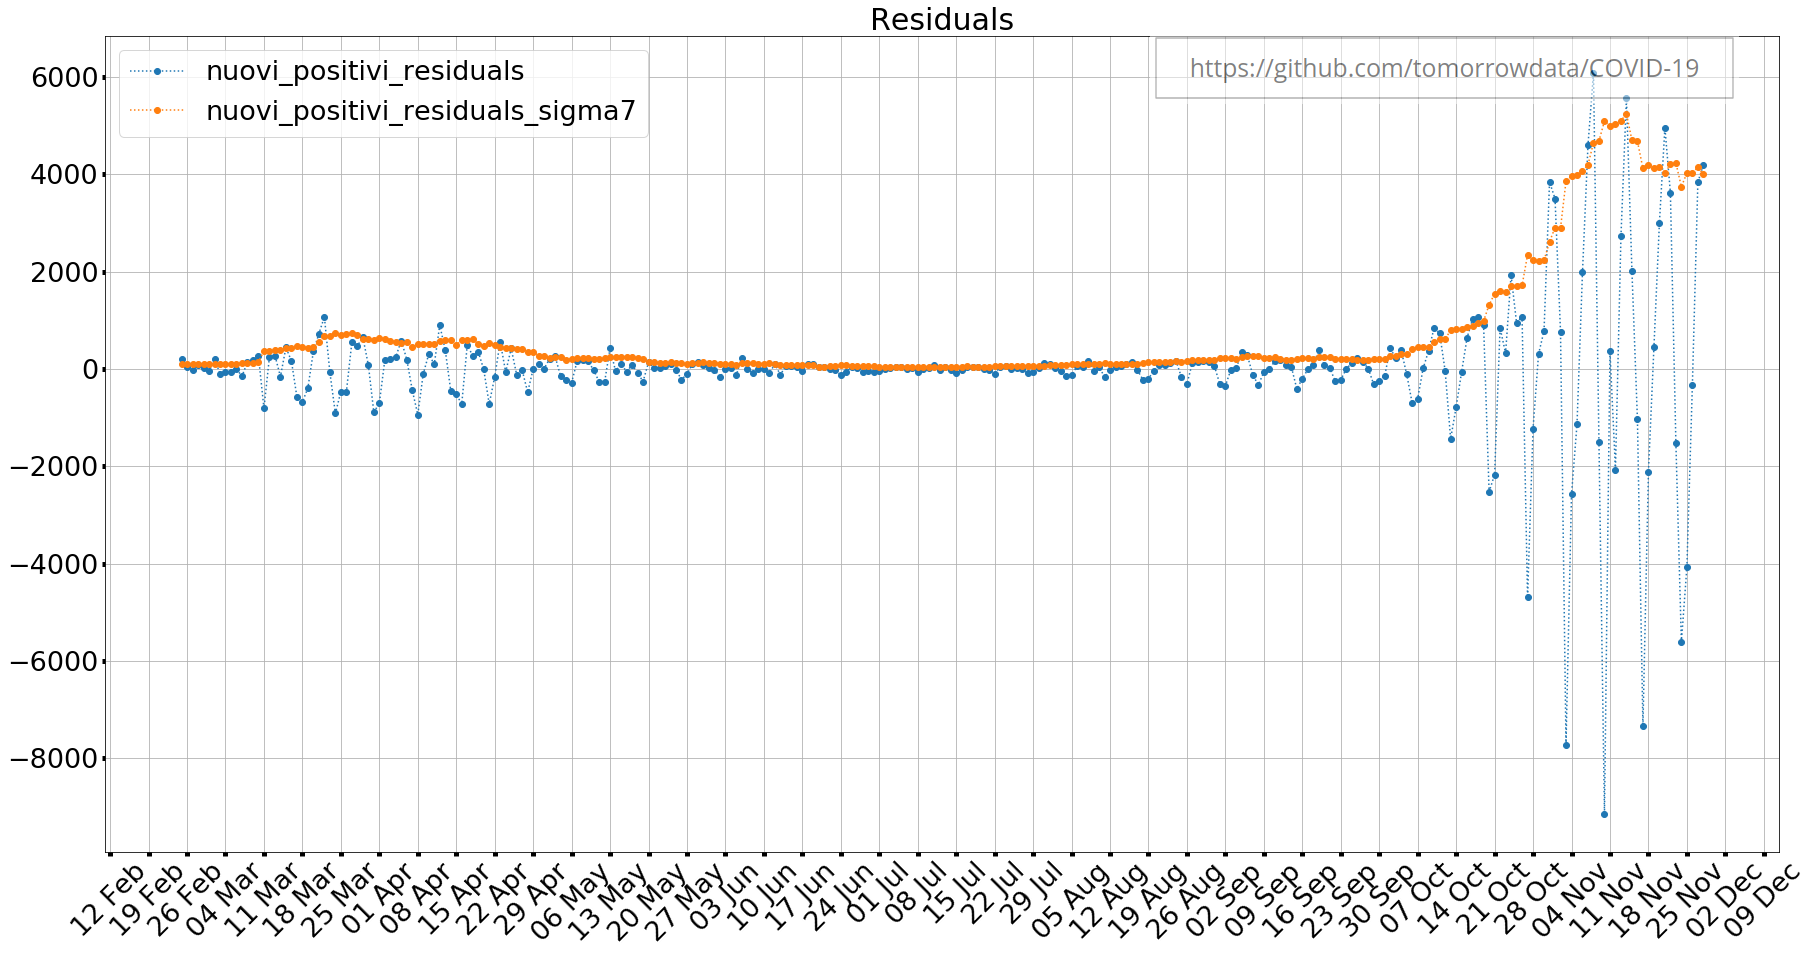

In [43]:
plot_series(
    'Residuals',    
    italy_raw_data, 
    [
        'nuovi_positivi_residuals',
        'nuovi_positivi_residuals_sigma7',
    ],
    #ylim=(0.2,3)
)

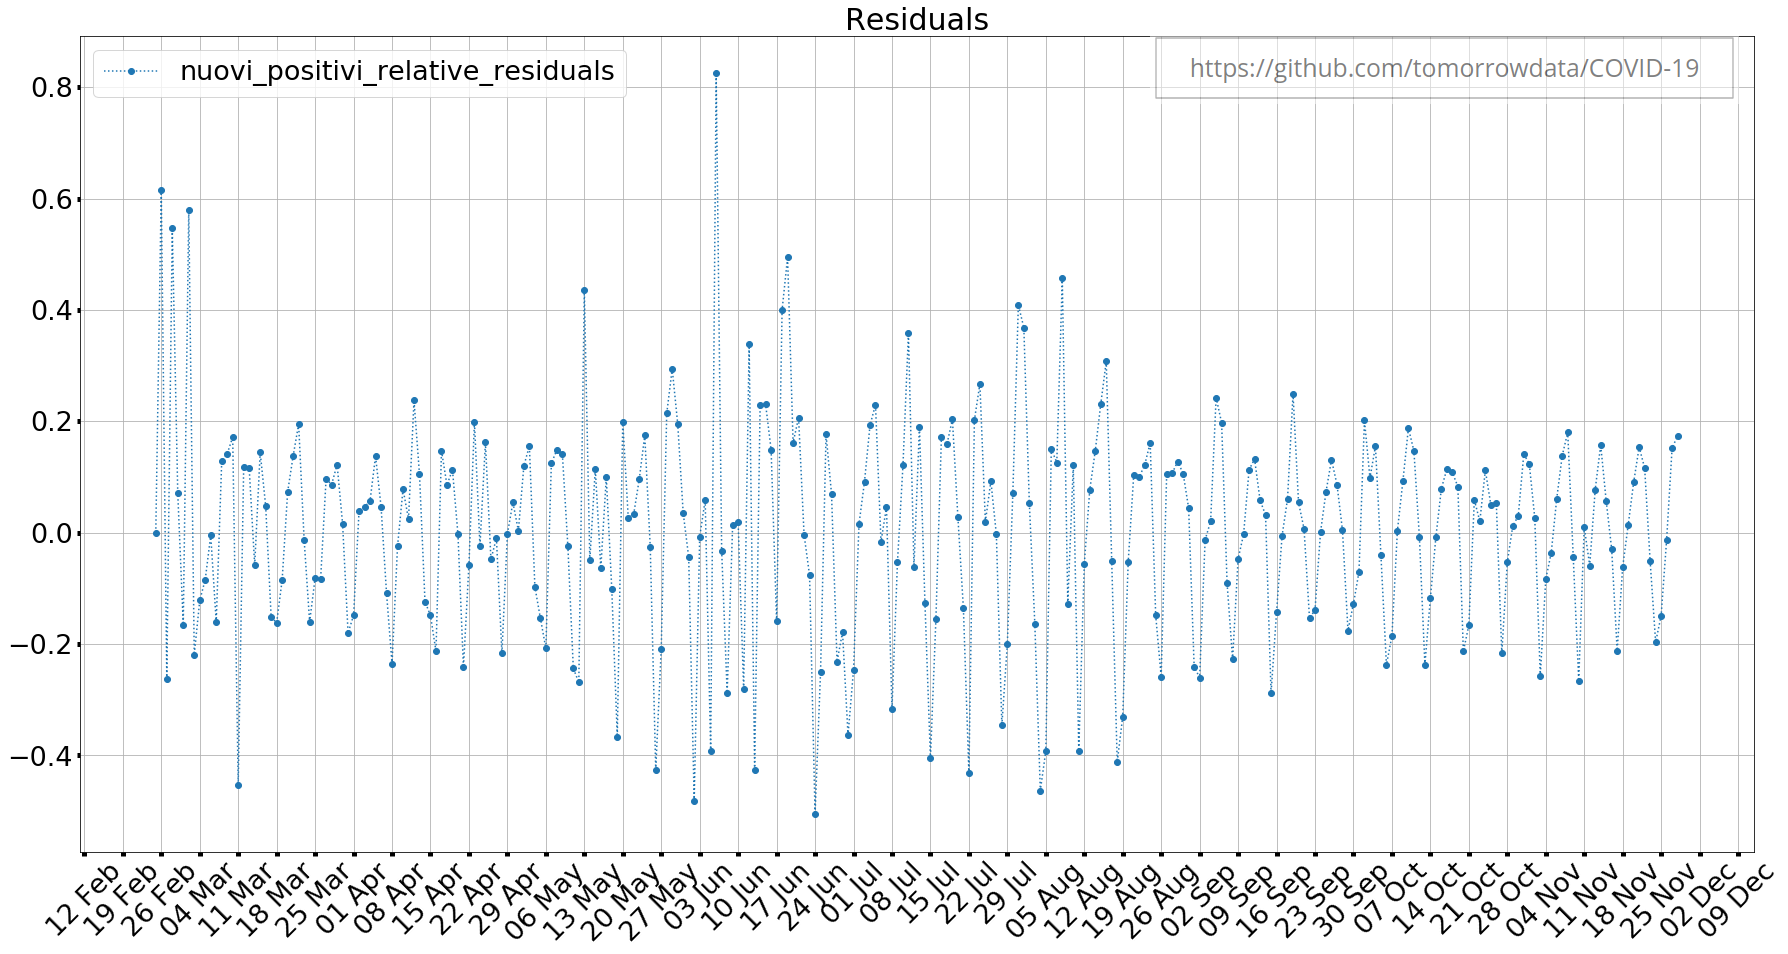

In [44]:
plot_series(
    'Residuals',    
    italy_raw_data, 
    [
        'nuovi_positivi_relative_residuals'
    ],
    #ylim=(0.2,3)
)

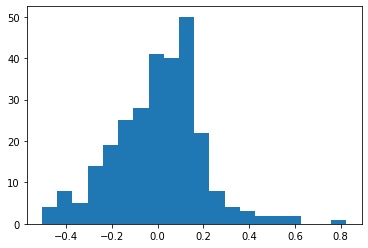

In [45]:
_= plt.hist(italy_raw_data.nuovi_positivi_relative_residuals, bins=20)

# Compute $R_t$

Definitions and parameters values are form Ref: https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt

$R_t$ si defined as:

$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

Where:
- $I_t$ is `nuovi_positivi` at day t, or any first difference of a cumulative value
- $w_s=\Gamma(s; \alpha,\beta)$, [the Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
- $\alpha = 1.87$
- $\beta = 0.28$

In [46]:
def gamma_df(x, alpha, beta):
    return stats.gamma.pdf(x, a=alpha, scale=1/beta)

In [47]:
def gamma_pf(x, alpha, beta):
    return stats.gamma.ppf(x, a=alpha, scale=1/beta)

In [48]:
def infectious_charge(series, alpha, beta):
    steps = len(series)
    x = np.linspace(1,steps-1, steps)
    w = gamma_df(x, alpha, beta)
    
    infectious_charge_ = [np.nan] + [
        sum(series[t-1::-1]*w[:t]) 
        for t in range(1, steps)        
    ]
    
    return np.asarray(infectious_charge_)

In [49]:
def Rt(series, alpha, beta):
    infectious_charge_ = infectious_charge(series, alpha, beta)
    
    return series / infectious_charge_

## Compute $R_t$ on every first difference available

Computation is performed for the following fields:
- `nuovi_positivi`: first difference of `nuovi_casi`
- `nuovi_casi_da_sospetto_diagnostico`: first difference of `casi_da_sospetto_diagnostico`
- `nuovi_casi_da_screening`: first difference of `casi_da_screening`

Each computation is performed both on the raw values **and on the smoothed values**.

In [50]:
alpha = 1.87
beta = 0.28

rt_on_fields = [
    'nuovi_positivi',
    'nuovi_casi_da_sospetto_diagnostico',
    'nuovi_casi_da_screening'
]

for c in rt_on_fields + ['{}_smoothed'.format(c) for c in rt_on_fields]:
    italy_raw_data['{}_Rt'.format(c)] = Rt(italy_raw_data[c], alpha=alpha, beta=beta).fillna(0)

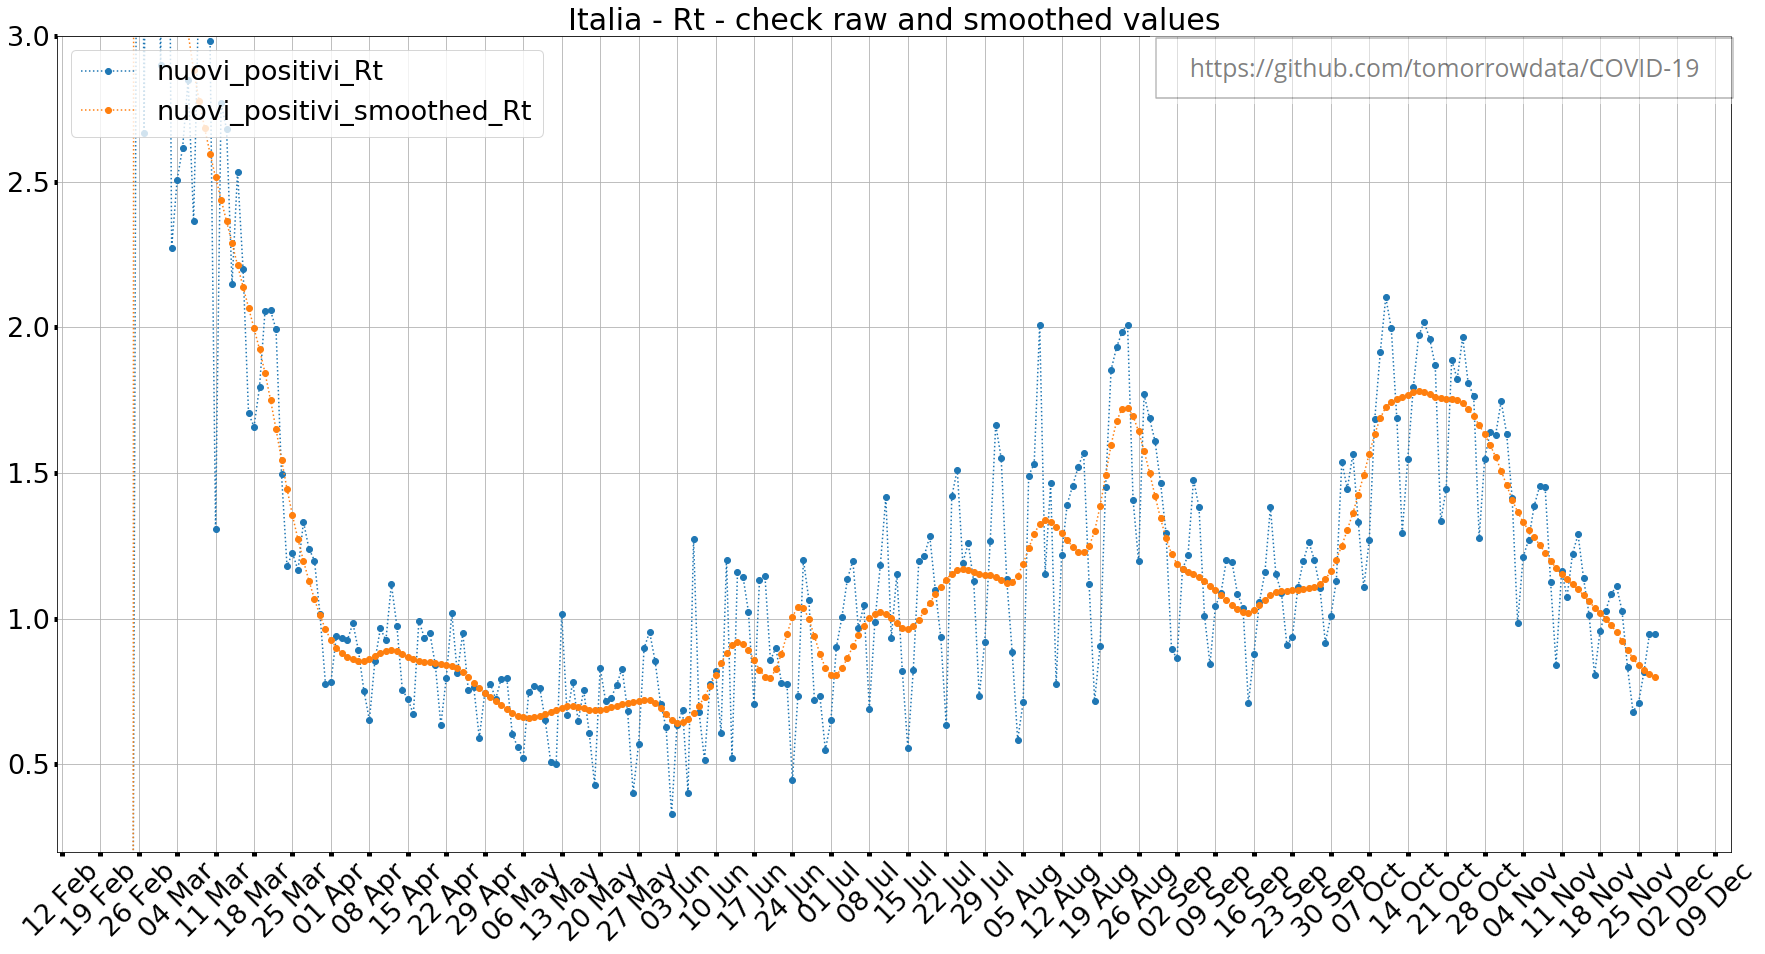

In [51]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.2,3)
)

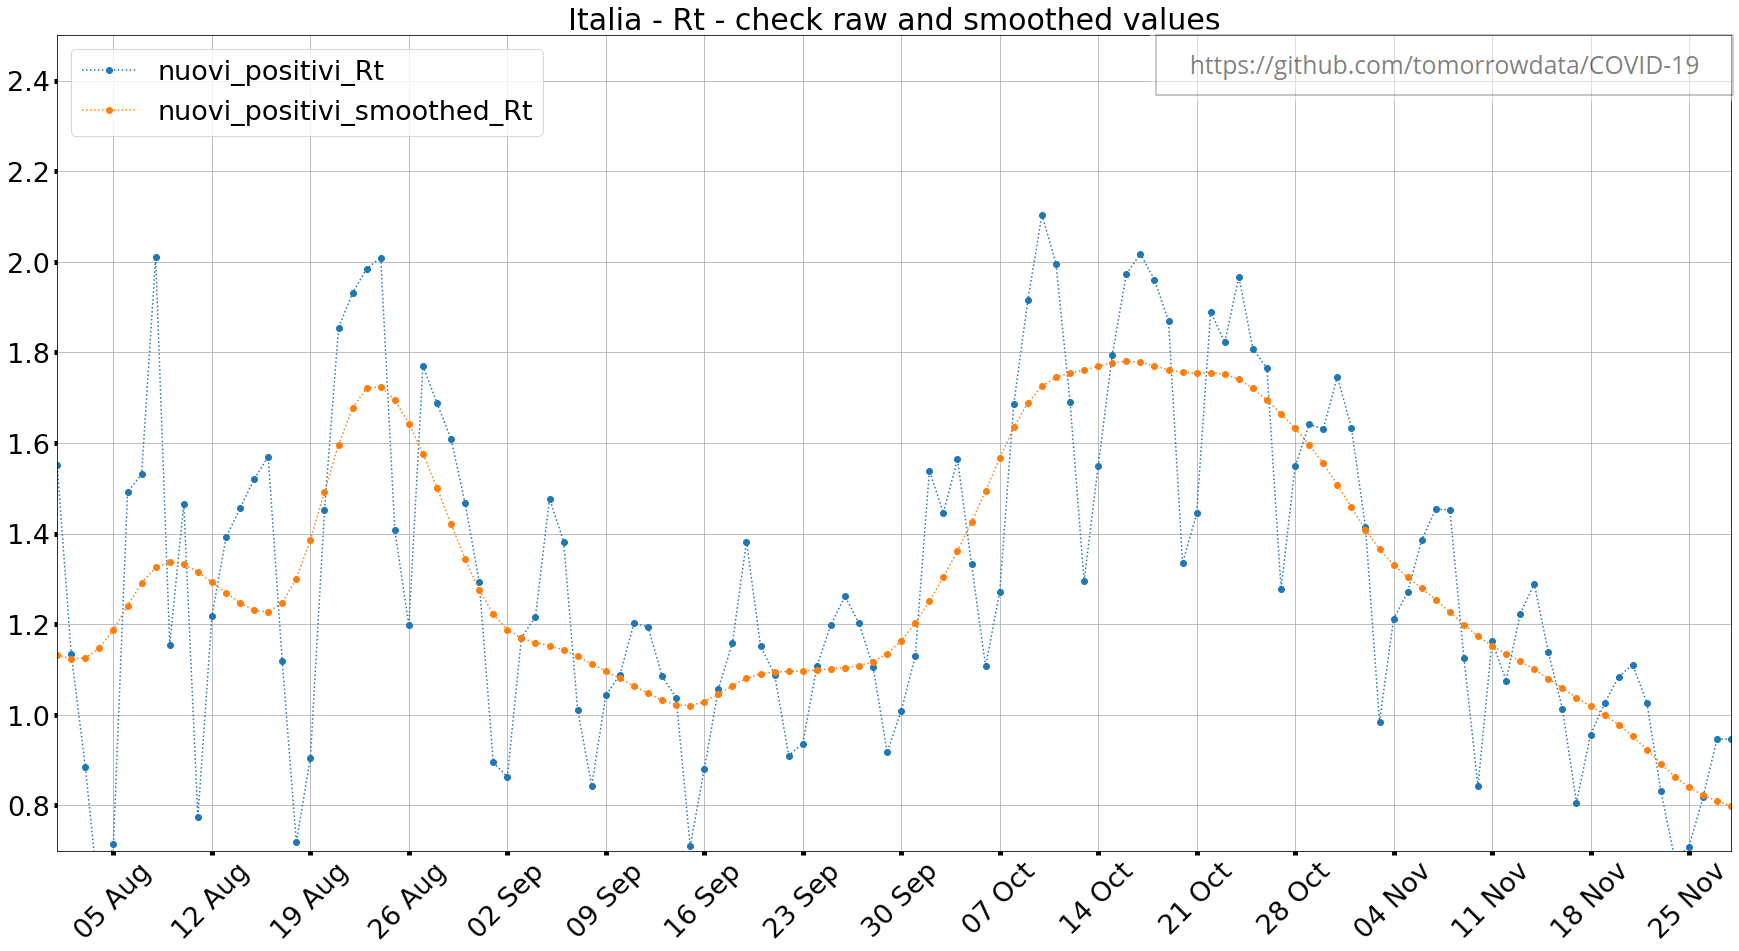

In [52]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.7,2.5),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

## Compare $R_t$ values computed on the 3 first differences

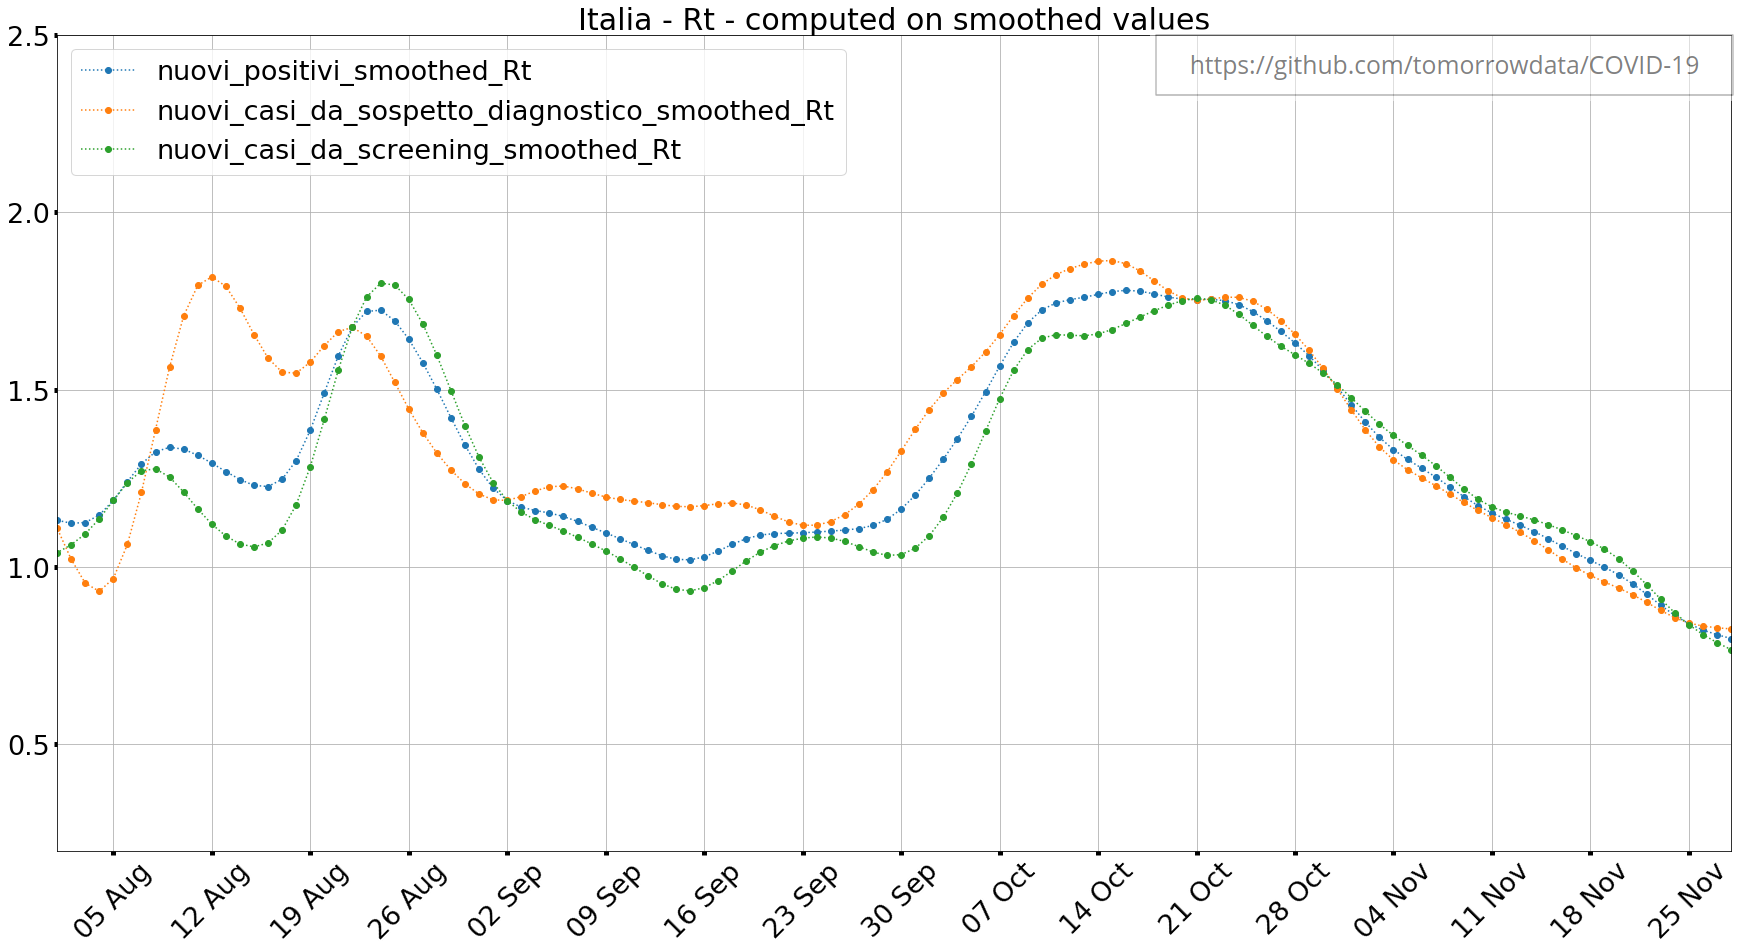

In [53]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

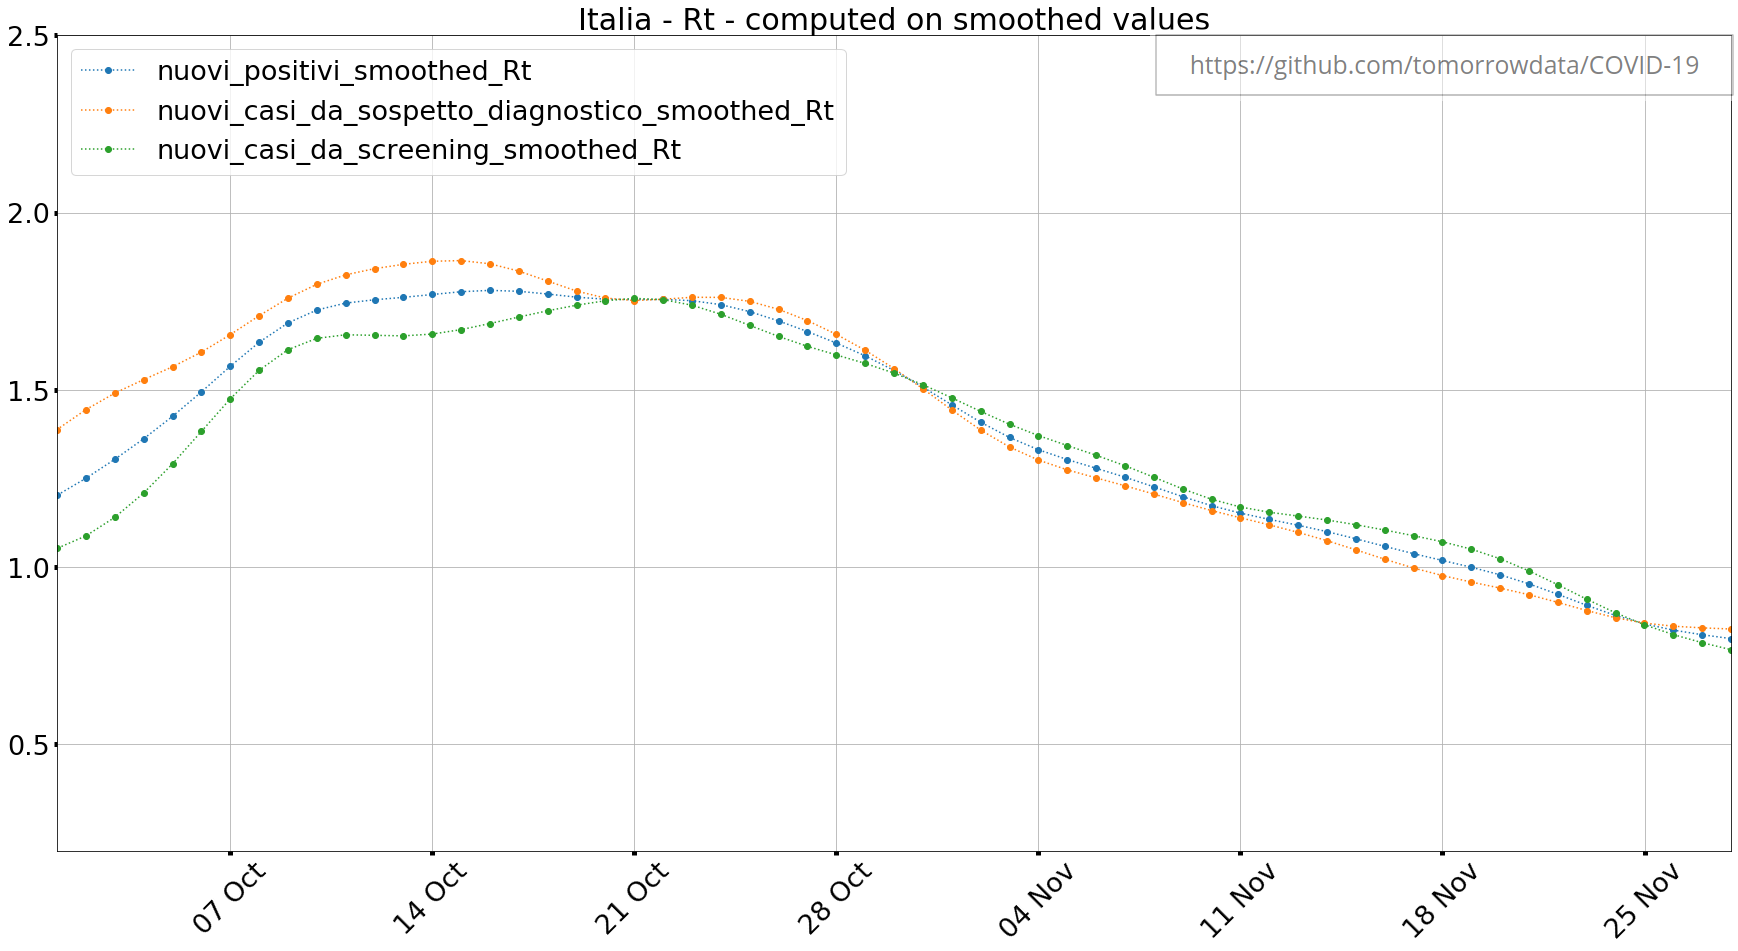

In [54]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,10,1),italy_raw_data.data.max())
)

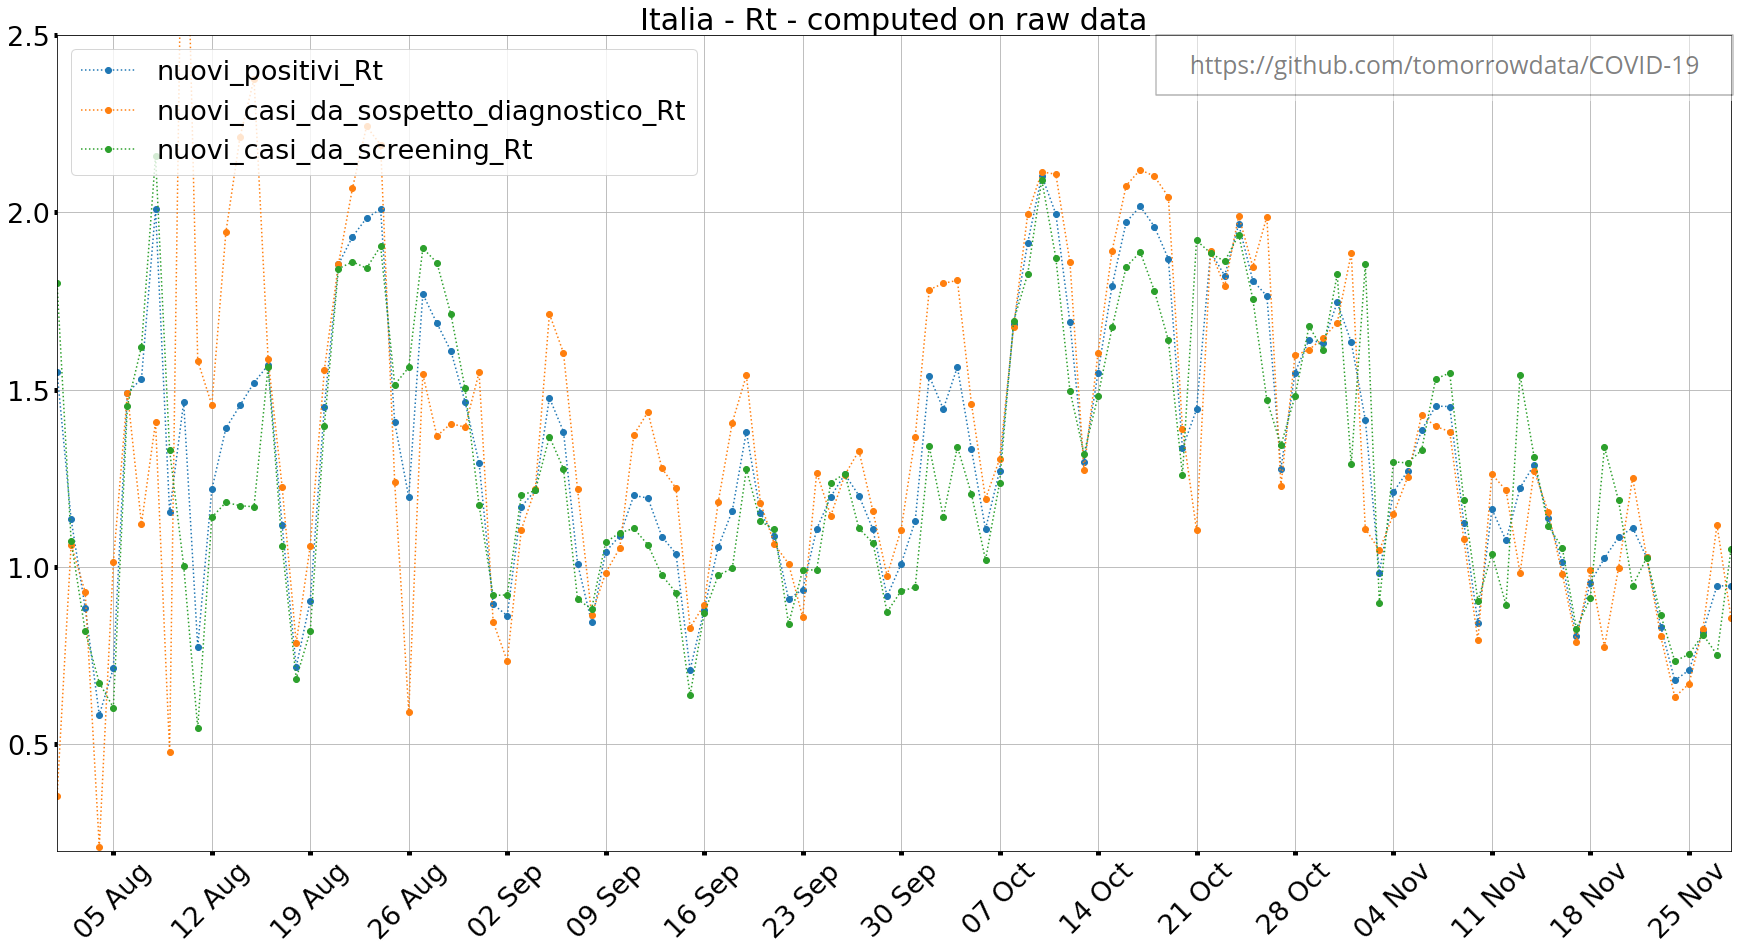

In [55]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_casi_da_sospetto_diagnostico_Rt',
        'nuovi_casi_da_screening_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

# Assess $R_t$ via perturbations

Let's add a perturbation $p_t$ to the original cumulative signal, and compute again the first difference:

$$\large{C_t = \sum_{s=1}^{t} I_t}$$

$$\large{\hat{C}_t = C_t + p_t}$$

$$\large{\hat{I}_t = \hat{C}_t-\hat{C}_{t-1}}$$


## Rate perturbation

The rate pertubation is defined as:

$$\large{p_{t+1} = p_t  (1+r_t)} $$

where:
- $r_t$ is the growth rate of the perturbation; it can be a function of time.

In [56]:
def growth(v,rate, zerosteps, steps):
    assert(zerosteps < steps)
    if isinstance(rate, Number):
        ratefunc = lambda s: rate
    elif callable(rate):
        ratefunc = rate
    else:
        raise Exception("rate must be either a number or a function")
    for s in range(steps):
        if s <= zerosteps:
            yield 0.
        else:
            r = ratefunc(s)
            v = v * (1. + r)
            yield v

In [57]:
p0 = 40.
rate=0.1
perturbation = pd.Series(growth(p0,rate, FIRST_CASI_SOSP_DIAGNOSTICO, TIMESTEPS))

cumulative_hat = italy_raw_data.casi_da_sospetto_diagnostico + perturbation

nuovi_casi_hat = smooth_differentiate(
    cumulative_hat,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

nuovi_perturbation = smooth_differentiate(
    perturbation,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

Rt_nuovi_casi_hat = Rt(nuovi_casi_hat, alpha=alpha, beta=beta)
Rt_perturbation = Rt(nuovi_perturbation, alpha=alpha, beta=beta)

italy_raw_data['perturbation_Rt'] = Rt_perturbation
italy_raw_data.perturbation_Rt.fillna(0, inplace=True)

italy_raw_data['casi_da_sospetto_diagnostico_smoothed_perturbed_Rt'] = Rt_nuovi_casi_hat
italy_raw_data.casi_da_sospetto_diagnostico_smoothed_perturbed_Rt.fillna(0, inplace=True)


TIC R2: 0.9999949950391261
TIC R2: 0.9999954151096114


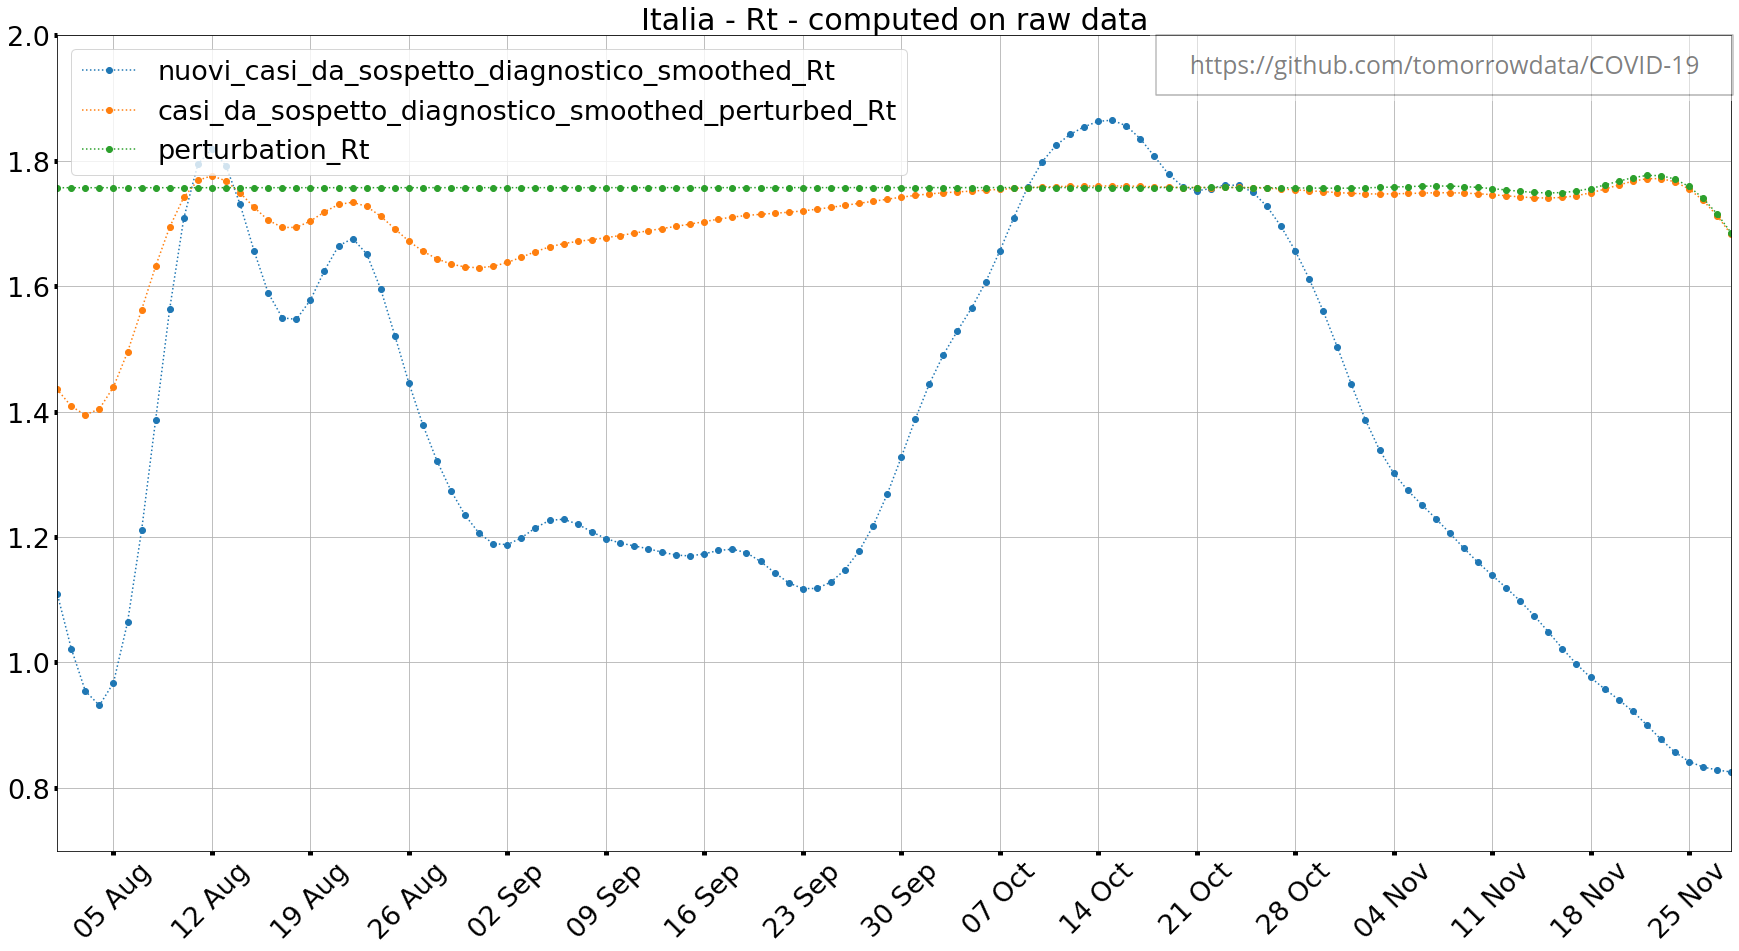

In [58]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'casi_da_sospetto_diagnostico_smoothed_perturbed_Rt',
        'perturbation_Rt'
    ],
    ylim=(0.7,2),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

# Comparison of ISS and realtime Rt values

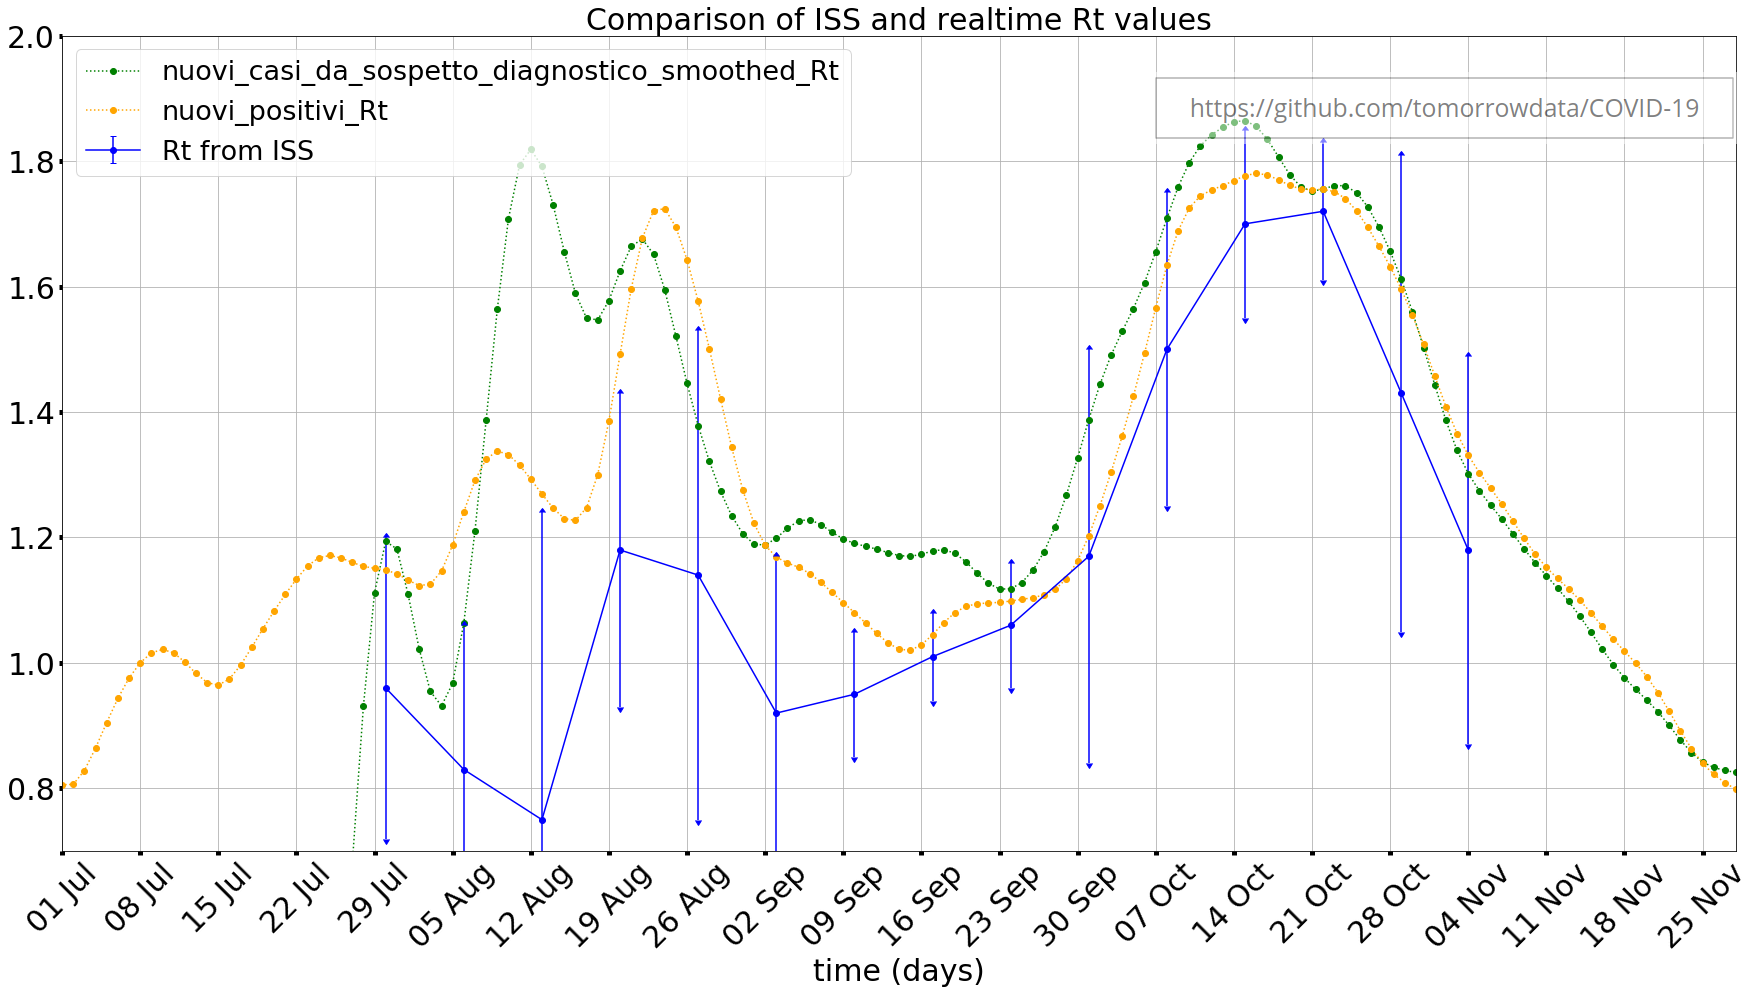

In [59]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Comparison of ISS and realtime Rt values', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax1.xaxis.set_tick_params(width=5)
ax1.yaxis.set_tick_params(width=5)
ax1.grid()    
with open('./images/watermark.png', 'rb') as file:
    im = image.imread(file)
fig.figimage(im, 1150, 850, zorder=3, alpha=.5)        

ax1.set_ylim(0.7,2)
ax1.set_xlim(datetime(2020,7,1),italy_raw_data.data.max())

ax1.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_casi_da_sospetto_diagnostico_smoothed_Rt, 
    label='nuovi_casi_da_sospetto_diagnostico_smoothed_Rt', 
    linestyle=':', marker='o', color = 'green'
)

ax1.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_positivi_smoothed_Rt, 
    label='nuovi_positivi_Rt', 
    linestyle=':', marker='o', color = 'orange'
)

ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS',
    marker='o', color = 'blue'
)


_ = ax1.legend(fontsize=27, loc='upper left')    

# Estimating $R_t$ with Markov chain Monte Carlo

In [60]:
def pad_window(a, start, window=None):
    if not window:
        window = 0
    
    return np.pad(
        a,
        [(start+1,window)] + [(0,0)]*(len(a.shape)-1), 
        mode='constant', 
        constant_values=np.nan
    )

def save_MCMC_sampling(df, column, trace, interval=0.95, start=0, window=None):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df['{}_Rt_MCMC'.format(column)] = pad_window(sampling_mean, start, window)
    
    df['{}_Rt_MCMC_avg14'.format(column)] = df['{}_Rt_MCMC'.format(column)].rolling(
        window=14, center=True
    ).mean()
    
    # confidence interval 14
    conf_int_14 = stats.norm.interval(
        interval, 
        df['{}_Rt_MCMC_avg14'.format(column)],
        df['{}_Rt_MCMC'.format(column)].rolling(
                window=14, center=True
        ).std()
    )
    
    df['{}_Rt_MCMC_CI_{}_14_min'.format(column, interval_frac)] = conf_int_14[0]
    df['{}_Rt_MCMC_CI_{}_14_max'.format(column, interval_frac)] = conf_int_14[1]

    #credible interval
    sampling_hdi = pad_window(
        pm.stats.hpd(trace['r_t'], hdi_prob=interval), 
        start, window
    )


    df['{}_Rt_MCMC_HDI_{}_min'.format(column, interval_frac)] = sampling_hdi[:,0]
    df['{}_Rt_MCMC_HDI_{}_max'.format(column, interval_frac)] = sampling_hdi[:,1]

    # confidence interval
    conf_int = stats.norm.interval(
        interval, 
        sampling_mean,
        np.std(trace['r_t'], axis=0)
    )

    df['{}_Rt_MCMC_CI_{}_min'.format(column, interval_frac)] = pad_window(conf_int[0], start, window)
    df['{}_Rt_MCMC_CI_{}_max'.format(column, interval_frac)] = pad_window(conf_int[1], start, window)
    
    

In [61]:
def MCMC_sample(
    onset, 
    alpha, 
    beta, 
    start=0, window=None, 
    chains=1, tune=4000, draws=4000, 
    target_accept=0.95, 
    dry=False, 
    cores=None
):

    if not window:
        window = len(onset)
    onset_ = onset[start:start+window]
    
    with pm.Model() as model:
                
        # draws R_t from a prior normal distribution
        r_t = pm.Normal("r_t", mu=1.3, sigma=10., shape=len(onset_)-1)

        # compute the exptect number of current infectious 
        # based on the sampled R_t and the know past values of infectious
        infectious_charge_ = infectious_charge(onset_, alpha, beta)[1:]
        expected_today = r_t * infectious_charge_
        
        # Poisson requirements
        mu = pm.math.maximum(.1, expected_today)        
        observed = (onset_.values[1:]).round()

        # test the posterior: 
        # mu values derived from R_t samples 
        # must converge to the mean of real cases 
        # if they are Poisson distributed, as they are
        cases = pm.Poisson('cases', mu=mu, observed=observed)

        trace = None
        if not dry:
            trace = pm.sample(
                chains=chains,
                cores=cores,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
        
            #assert not trace.diverging.any()
    
    return model, trace

## Sample $R_t$ distribution on `nuovi_positivi` smoothed series

Two problems, two fixes:

### onset date is not know in real-time

we must wait for the onset cases to be confirmed by physician/test.

Hence, we approximate the onset date with the confirmation date ->

`today onset cases` are approximated by `today nuovi positivi` cases.

TODO: if raw data from ISS would be available, we could evaluate the impacts of this approximation on the credible interval of the estimated $R_t$

### noise in the raw data

Use data which are smoothed by means of Tikhonov regression

In [62]:
model_, trace_ = MCMC_sample(
    onset=italy_raw_data.nuovi_positivi_smoothed,
    alpha=alpha, beta=beta,
    start=0, window=None,
    chains=4,
    tune=4000,
    draws=4000,
    dry=False
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 31 seconds.


In [63]:
save_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi_smoothed', 
    trace_, 
    start=0, window=None
)

nuovi_positivi_smoothed_Rt_MCMC_HDI_95_min


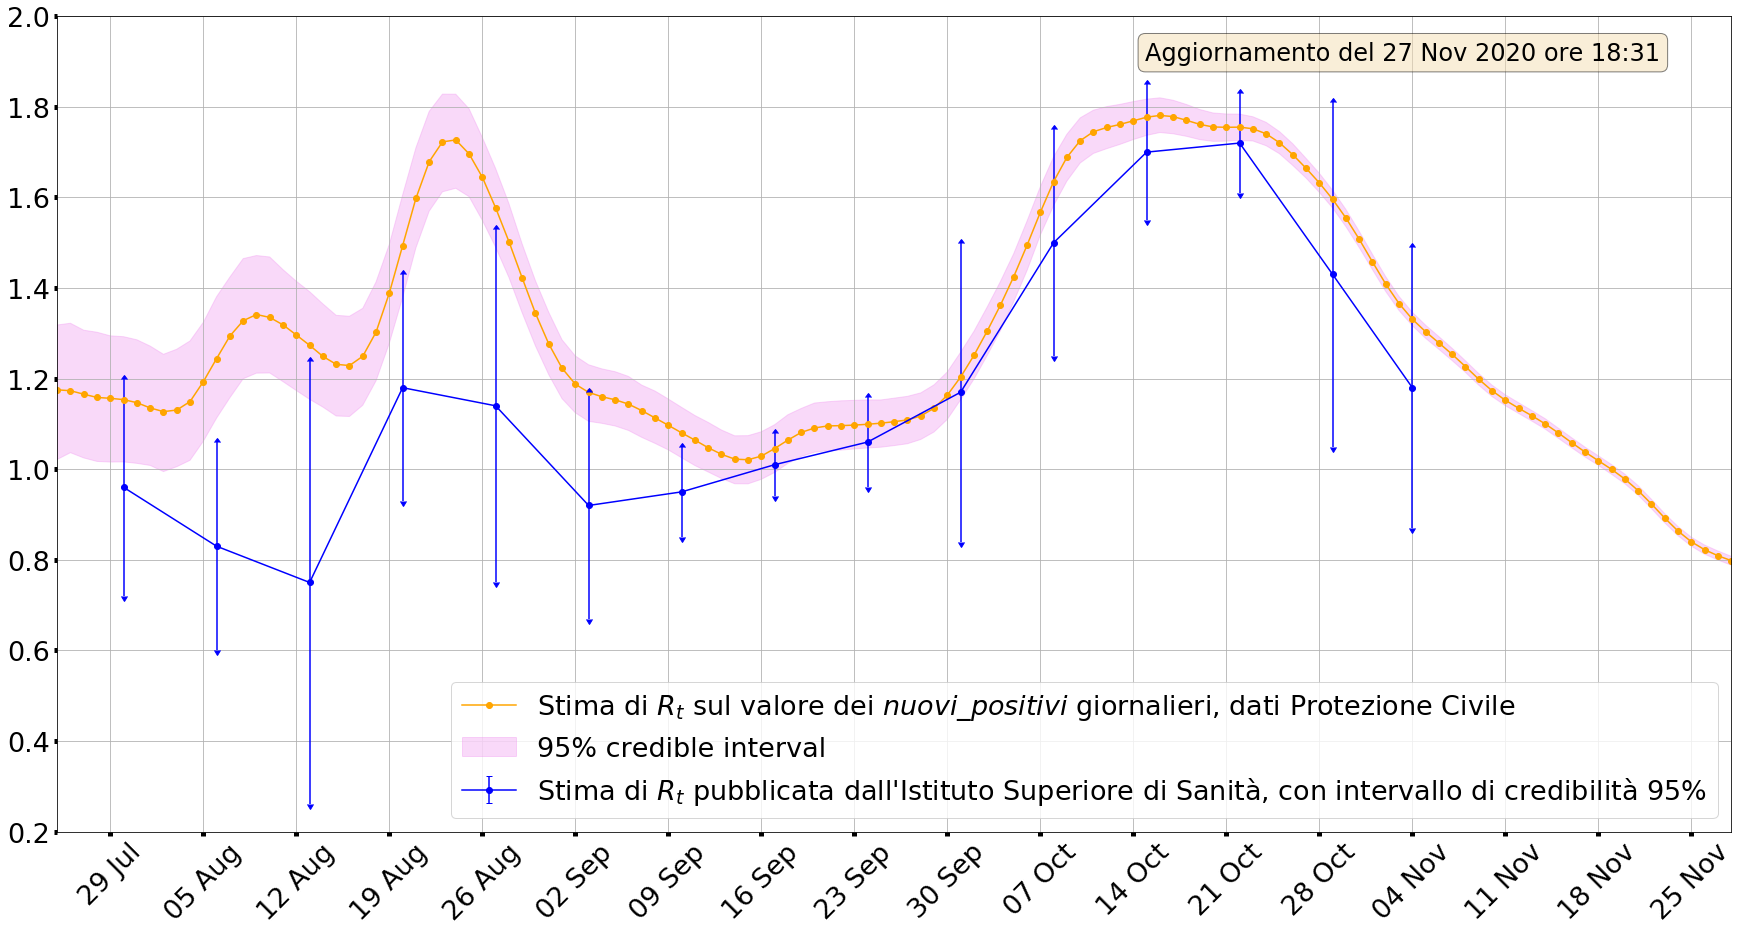

In [66]:

plot_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi_smoothed', 
    ISS_Rt_clean,
    xlim=(datetime(2020,7,25),italy_raw_data.data.max()), 
    std=False, 
    average=False, 
    ylim=(0.2,2),
    path='./images/{}_MCMC_Rt_computation_300dpi.png'.format(italy_raw_data.data.max().strftime('%Y%m%d')), 
    dpi=300
)